# Executor Data Overhead

In [1]:
from __future__ import annotations

import importlib
import json
import os
import pathlib

import seaborn
import polars
from matplotlib import pyplot as plt

polars.Config.set_tbl_rows(100)

polars.config.Config

In [2]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            if task_info['function_name'] == 'noop_task':
                execution_info = task_info.pop('execution')
                task_info = {**task_info, **execution_info}
                tasks.append(task_info)

    return polars.DataFrame(tasks)

def get_info_from_log(filepath: pathlib.Path) -> dict:
    with open(filepath) as f:
        for line in f.readlines():
            if "name='synthetic'" in line:
                config = line
                break

    for term in config.split(' '):
        if 'task_data_bytes' in term:
            size = int(term.split('=')[1][:-1])
            break
    else:
        raise ValueError('Size not found')

    for term in config.split(' '):
        if 'task_count' in term:
            count = int(term.split('=')[1][:-1])
            break
    else:
        raise ValueError('Size not found')
    
    if "NullTransformerConfig" in config:
        transformer = "Baseline (None)"
    elif "PickleFileTransformerConfig" in config:
        transformer = "Pickle File"
    elif "ProxyFileTransformerConfig" in config:
        if "ps_type='file'" in config:
            transformer = "ProxyStore (File)"
        elif "ps_type='redis'" in config:
            transformer = "ProxyStore (Redis)"
    else:
        raise ValueError(config)

    return {'transformer': transformer, 'size': size, 'count': count}
    

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.json'):
        app, executor, timestamp = str(tasks_path.relative_to(directory).parent).split('/')
        
        tasks = load_tasks(tasks_path)
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()

        info = get_info_from_log(tasks_path.parent / 'log.txt')
        task_time = end_time - start_time

        run_info = {
            'app': app,
            'executor': executor,
            'timestamp': timestamp,
            'transformer': info['transformer'],
            'data-size-bytes': info['size'],
            'task-count': info['count'],
            'total-time': task_time,
            'avg-task-time-ms': 1000 * task_time / info['count']
        }
        runs.append(run_info)

    return polars.DataFrame(runs)

In [3]:
data = load_data(pathlib.Path('../runs/data/'))
data = data.filter(polars.col('transformer') != 'ProxyStore (File)')

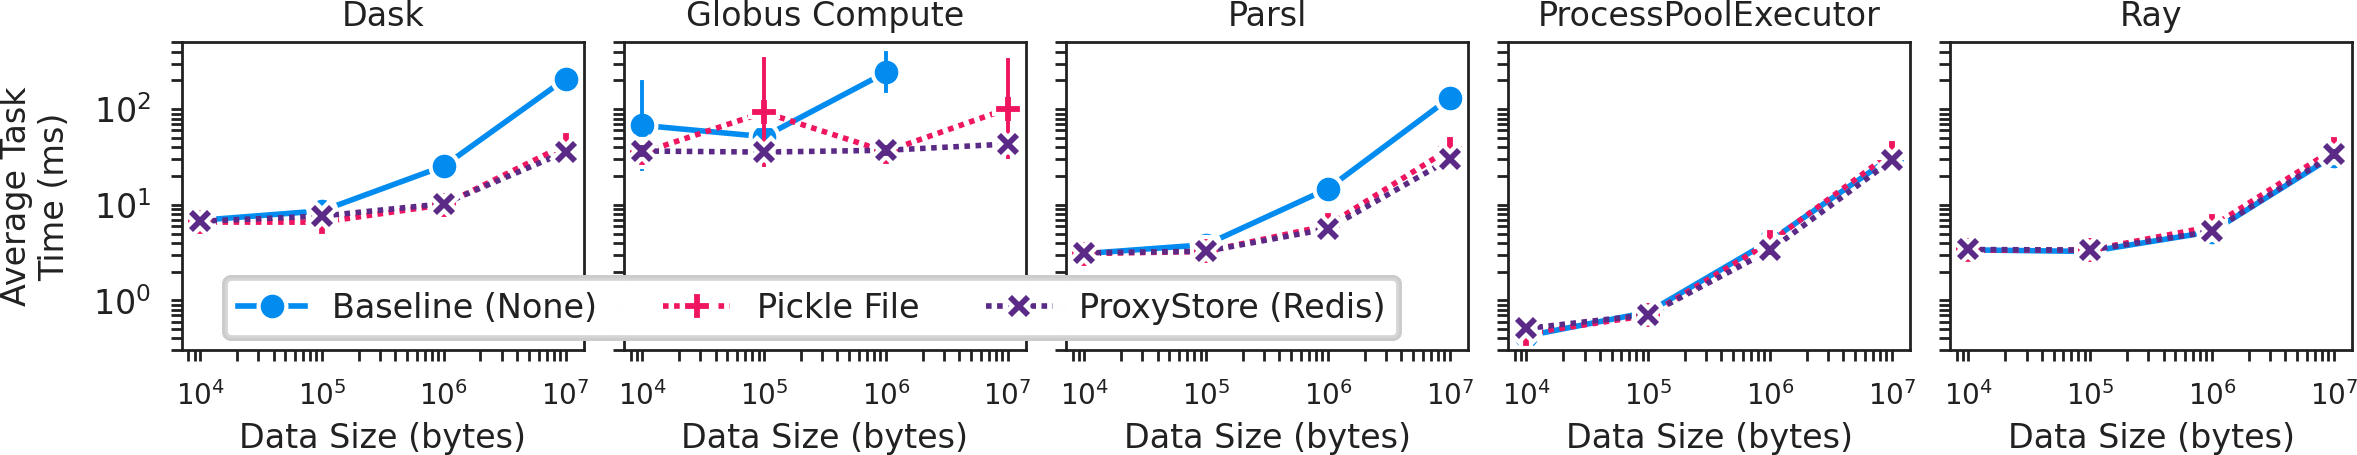

In [4]:
rows, cols = 1, 5
fig, axes = plt.subplots(rows, cols, sharey=True)
executors = sorted(set(data['executor']))
transformers = sorted(set(data['transformer']))
names = {
    'dask': 'Dask',
    'globus-compute': 'Globus Compute',
    'parsl': 'Parsl',
    'process-pool': 'ProcessPoolExecutor',
    'ray': 'Ray',
}
colors = {executor: color['color'] for executor, color in zip(executors, plt.rcParams['axes.prop_cycle'])}
colors = {
    'Baseline (None)': '#028CF0',
    'Pickle File': '#EF1561',
    'ProxyStore (Redis)': '#5B2A86',
}
dashes = {
    'Baseline (None)': (),
    'Pickle File': (1, 1),
    'ProxyStore (Redis)': (1, 1),
}
markers = {
    'Baseline (None)': 'o',
    'Pickle File': 'P',
    'ProxyStore (Redis)': 'X',
}

for x in range(cols):
    if x >= len(executors):
        continue
    executor = executors[x]

    subdata = data.filter(
        polars.col('executor') == executor,
    )
    ax = axes[x]
    seaborn.lineplot(
        ax=ax,
        data=subdata,
        hue_order=transformers,
        y='avg-task-time-ms',
        x='data-size-bytes',
        hue='transformer',
        style='transformer',
        errorbar='sd',
        err_style='bars',
        palette=colors,
        dashes=dashes,
        markers=markers,
        linewidth=1,
        markersize=5,
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(names[executor], pad=3)
    ax.set_ylabel('Average Task\nTime (ms)')
    ax.tick_params(axis='x', labelsize=5)
    ax.set_xlabel('Data Size (bytes)', labelpad=2)
            
    # ax.set_yticks(range(len(executors)))
    # ax.set_yticklabels([names[name] for name in executors])
    # l, r = ax.get_xlim()
    # ax.set_xlim(l * 1.05, r * 1.05)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncols=3, bbox_to_anchor=(0.35, 0.1))
    # fig.legend(handles, labels, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.4))
    ax.get_legend().remove()
    ax.set_ylim([0.3, 500])

# TODO: baseline as black dashed line, change colors, use markers with stdev
plt.subplots_adjust(wspace=0.1, hspace=0.5)
fig.set_size_inches(7, 1)
plt.savefig('../figures/data-transformers.pdf', pad_inches=0.05)
plt.savefig('../figures/data-transformers.svg', pad_inches=0.05)

In [5]:
data.group_by(['app', 'executor', 'transformer', 'data-size-bytes']).mean().sort('app', 'executor', 'data-size-bytes', 'transformer').select('executor', 'data-size-bytes', 'avg-task-time-ms')

executor,data-size-bytes,avg-task-time-ms
str,i64,f64
"""dask""",10000,6.895914
"""dask""",10000,6.604419
"""dask""",10000,6.746891
"""dask""",100000,8.673092
"""dask""",100000,6.591415
"""dask""",100000,7.642128
"""dask""",1000000,25.443785
"""dask""",1000000,10.041375
"""dask""",1000000,10.277033
